In [1197]:
%load_ext autoreload
%autoreload 2
import gc
import sys

gc.collect()

paths_to_add = ['/home/jovyan/work', '/home/jupyter/alpha_media_signal']

for p in paths_to_add:
    if p not in sys.path:
        sys.path.append(p)

import pandas as pd

from ams.services.equities.EquityFundaDimension import EquityFundaDimension
%matplotlib inline
from pathlib import Path

from ams.config import constants
from ams.services import twitter_service
from ams.services import ticker_service

from statistics import mean
import numpy as np
from ams.services import file_services
from typing import List

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1363]:
model_mode = "train"

twitter_folder = 'twitter'

tr_file_path = Path(constants.TWITTER_OUTPUT_RAW_PATH, "tip_ranked", "main", "tip_rank_2020-12-14_22-48-27-354.17.parquet")

learning_prep_dir = Path(constants.DATA_PATH, twitter_folder, "great_reduction", "main")

file_paths = file_services.list_files(parent_path=learning_prep_dir, ends_with=".parquet", use_dir_recursion=True)    

In [1364]:
%%time

all_dfs = []
for f in file_paths:
    df = pd.read_parquet(f)
    all_dfs.append(df)

df_twitter_raw = pd.concat(all_dfs, axis=0)

cat_uniques = None
model_xgb = None
if model_mode == "predict":
    model_xgb: twitter_ml_utils.TwitterModelPackage = pickle_service.load(constants.TWITTER_XGB_MODEL_PATH)
    cat_uniques = model_xgb.cat_uniques
    
    print(len(cat_uniques["f22_ticker"]))
    #today_dt_str = date_utils.get_standard_ymd_format(datetime.now())
    predict_date_str = "2020-12-24"
    
    df_twitter_raw = df_twitter_raw[df_twitter_raw["date"] == predict_date_str]

    
max_date = df_twitter_raw["date"].max()
print(f"Max date: {max_date}")
print(f"Count: {df_twitter_raw.shape[0]}")

Max date: 2020-12-27
Count: 228582
Wall time: 1.53 s


Wall time: 515 ms


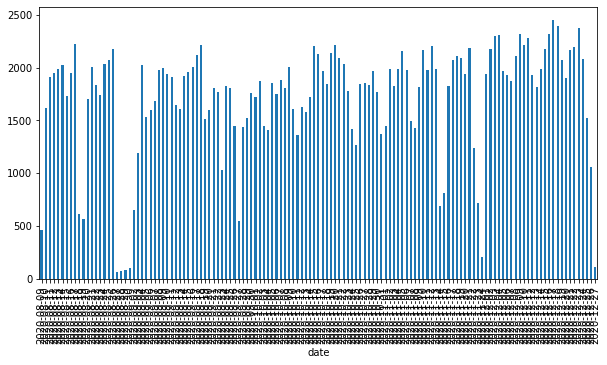

In [1365]:
%%time 

twitter_ml_utils.show_distribution(df=df_twitter_raw)

In [1366]:
%%time

df_booled = twitter_service.convert_to_bool(df=df_twitter_raw)

Wall time: 3.4 s


In [1367]:
%%time

df_twitter = twitter_ml_utils.convert_twitter_to_numeric(df=df_booled)

Wall time: 47 ms


In [1368]:
%%time
num_hold_days = 5

df_stock_data = twitter_service.get_stock_data_for_twitter_companies(df_tweets=df_twitter, 
                                                                     num_days_in_future=num_hold_days)
df_stock_data["date"].max()

Wall time: 36 s


'2020-12-24'

In [1369]:
df_stock_data.sort_values(by=["date"], ascending=False)[["date", "future_date"]].head()

if model_mode == "predict":
    df_stock_data = twitter_ml_utils.add_future_date_for_nan(df=df_stock_data, num_days_in_future=num_hold_days)
else:
    df_stock_data = df_stock_data.dropna(subset=["future_open", "future_low", "future_high", "future_close", "future_date"])

df_stock_data.sort_values(by=["future_date"], ascending=False)["future_date"].head()

1261    2020-12-24
126     2020-12-24
561     2020-12-24
273     2020-12-24
799     2020-12-24
Name: future_date, dtype: object

In [1370]:
%%time

df_rec_quart_drop = twitter_service.get_all_quarterly_data_for_twitter()

columns_fundy = list(df_rec_quart_drop.columns)

Wall time: 6.44 s


In [1371]:
%%time

df_result = twitter_ml_utils.merge_fundies_with_stock(df_stock_data=df_stock_data)

Wall time: 8.33 s


In [1372]:
df_drop_init = df_result.dropna(subset=["date"]).drop(columns="lastupdated_eq_fun")

df_drop_future = df_drop_init[df_drop_init["date"] > df_drop_init["calendardate"]]

df_drop_future = df_drop_future.sort_values(by=["ticker", "date", "calendardate"], ascending=False)

df_stock_and_quarter = df_drop_future.drop_duplicates(subset=["ticker", "date"], keep="first")

In [1373]:
df_nas_tickers_info, non_ticker_uniques = ticker_service.get_nasdaq_tickers(cat_uniques=cat_uniques)

col_tick = "f22_ticker"
tickers = None
if cat_uniques is not None and col_tick in cat_uniques.keys():
    tickers = cat_uniques[col_tick]
    
cat_uniques = non_ticker_uniques

if tickers is not None:
    cat_uniques[col_tick] = tickers

C:\Users\Chris\workspaces\alpha_media_signal\ams\services\ticker_service.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = df[c].fillna("<unknown>")
C:\Users\Chris\workspaces\alpha_media_signal\ams\services\ticker_service.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = df[c].astype(CategoricalDtype(uniques))


In [1374]:
%time

col_ticker = "ticker_drop"

df_stock_quart_info = pd.merge(df_stock_and_quarter, df_nas_tickers_info, how='inner', left_on=["ticker"], right_on=[col_ticker])
df_sqi = df_stock_quart_info.drop(columns=[col_ticker])

Wall time: 0 ns


In [1375]:
%%time

df_stock_renamed = df_sqi.rename(columns={"ticker": "f22_ticker"})

if 'None' in df_stock_renamed.columns:
    df_stock_renamed = df_stock_renamed.drop(columns=['None'])

df_merged = pd.merge(df_twitter, df_stock_renamed, how='inner', left_on=["f22_ticker","date"], right_on=["f22_ticker","date"])

print(f'Num merged: {df_merged.shape[0]}')

Num merged: 205241
Wall time: 2.63 s


In [1376]:
df_days = twitter_ml_utils.add_days_since_quarter_results(df=df_merged)

In [1377]:
df_days["future_date"].max()

'2020-12-24'

In [1378]:
%%time

df_days_of = twitter_ml_utils.add_calendar_days(df=df_days)

df_days_of["future_date"].max()

Wall time: 12.7 s


'2020-12-24'

In [1379]:
%%time

df_dd = twitter_ml_utils.add_nasdaq_roi(df=df_days_of)

Wall time: 2.89 s


In [1380]:
%%time

if model_mode == "train":
    df_thin_rabbit = twitter_service.add_buy_sell(df=df_dd)
else:
    df_thin_rabbit = df_dd

Wall time: 205 ms


In [1381]:
df_thin_rabbit["original_close_price"] = df_thin_rabbit["close"]
df_thin_rabbit["date"].max()
print(f'Num df_thin_rabbit: {df_thin_rabbit.shape[0]}')

Num df_thin_rabbit: 102649


In [1382]:
# save_twitter_stock_join(df=df_thin_rabbit)

In [1383]:
%%time
cols_fundy_numeric = list(set(columns_fundy) - {"ticker", 'calendardate', 'datekey', 'reportperiod'})

df_no_z = twitter_service.fill_null_numeric(df=df_thin_rabbit, cols_fundy_numeric=cols_fundy_numeric)

Wall time: 395 ms


In [1384]:
%%time
    
df_since_sma = twitter_ml_utils.add_sma_stuff(df=df_no_z)

Wall time: 1min 32s


In [1385]:
%%time

df_since_sma["purchase_date"] = df_since_sma["date"]

Wall time: 1 ms


In [1386]:
%%time

df_days_until = ticker_service.add_days_until_sale(df=df_since_sma)

Wall time: 3.9 s


In [1387]:
%%time
df = twitter_service.refine_pool(df=df_days_until, min_volume=None, min_price=None, max_price=None)
df = twitter_service.omit_columns(df=df)
df_tweet_counted = twitter_service.add_tweet_count(df=df).drop(columns=["calendardate", "reportperiod", "dimension", "datekey"])

Wall time: 19.1 s


In [1388]:
df_tweet_counted["future_date"].max()

'2020-12-24'

In [1389]:
# df_winnowed = twitter_ml_utils.truncate_avail_columns(df=df_tweet_counted)

In [1390]:
print(df_tweet_counted.shape[0])

df_ranked = twitter_ml_utils.add_tip_ranks(df=df_tweet_counted, tr_file_path=tr_file_path)

102649


In [1391]:
df_ranked["future_date"].max()

'2020-12-24'

In [1392]:
print(df_ranked.shape[0])

df_ticker_hotted, unique_tickers = ticker_service.make_f22_ticker_one_hotted(df_ranked=df_ranked, cat_uniques=cat_uniques)
cat_uniques["f22_ticker"] = unique_tickers
print(f"{len(cat_uniques['f22_ticker'])}")

102649
cat_uniques is not used.
2572


In [1393]:
%%time

df_train = df_ticker_hotted

print(df_train.shape[0])
print(df_train["future_date"].max())
print(len(cat_uniques["f22_ticker"]))

if model_mode == "train":
    # sac_roi_list = twitter_ml_utils.find_ml_pred_perf(df=df_train)
#     sac_roi_list = twitter_ml_utils.torch_non_linear(df=df_train, narrow_cols=narrow_cols)
    sac_roi_list = twitter_ml_utils.xgb_learning(df=df_train, narrow_cols=narrow_cols, cat_uniques=cat_uniques)    

102649
2020-12-24
2572
Using GPU
Split | min: 2020-08-10 | max: 2020-12-17
Split dates for small dataset: ['2020-12-14', '2020-12-15', '2020-12-16', '2020-12-17']
Split | min: 2020-08-10 | max: 2020-12-11
Split dates for small dataset: ['2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22', '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26', '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30', '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04', '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08', '2020-12-09', '2020-12-10', '2020-12-11']
Original: 102649; train_set: 79275; test_set: 17975


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 2719])

In [1361]:
if model_mode == "train": 
    startup_cash = 1000

    investment = startup_cash
    for s in sac_roi_list:
        investment = (investment * s) + investment

    print(f"roi amount: {investment}")
    print(sac_roi_list)

In [1362]:
from ams.services import pickle_service

if model_mode == "predict":
    def get_data_for_predictions(df: pd.DataFrame, narrow_cols: List[str]):
        feature_cols = twitter_service.get_feature_columns(narrow_cols)

        return np.array(df[feature_cols])

    X_predict = get_data_for_predictions(df=df_ticker_hotted, narrow_cols=narrow_cols)

    prediction = model_xgb.model.predict(X_predict)

#     print(list(prediction[:10000]))
    
    df_ticker_hotted["prediction"] = prediction
    
    df_buy = df_ticker_hotted[df_ticker_hotted["prediction"] == 1][["f22_ticker", "prediction"]]
    print(df_buy.head(1000))
    
    